In [3]:
#pip install ee

In [4]:
#pip install geemap

In [5]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [6]:
lake = ee.FeatureCollection('projects/ee-touheda-khanom/assets/samplinglakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))


Map.addLayer(lake)
Map.centerObject(lake, 16)
Map

Map(center=[43.83093869244275, -74.84826397158908], controls=(WidgetControl(options=['position', 'transparent_…

In [7]:
station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)
Map.addLayer(station)
Map.centerObject(station, 16)


In [8]:
sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

In [9]:
def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1': img.select('Aerosols'),
        'b2': img.select('Blue'),
        'b3': img.select('Green'),
        'b4': img.select('Red')
    }).rename("CO")
    
    bad2 = cdo.where(cdo.gte(0), 1).rename("bad2")
    co = cdo.multiply(bad2).rename("CO")
    mask = co.neq(0)

    return img.addBands(co).clip(lake).updateMask(mask)


In [10]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage


s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(1, 12, 'month')) \
    .filterBounds(lake) \
    .map(maskS2clouds) \
    .select(sentinel2_bands, STD_NAMES) \
    .map(cdom)


In [11]:
 first_image = s2.first()  # Get the first image from the collection
band_names = first_image.bandNames().getInfo()
print("Band Names:", band_names)

Band Names: ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'CO']


In [12]:
#How many images?
print(s2.size().getInfo())


670


In [13]:
def station_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).get('CO')
    return img.set('date', img.date().format()).set('CDOM',mean)

station_reduced_imgs = s2.map(station_mean)
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','CDOM']).values().get(0)
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])

#df
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])
pd.set_option('display.max_rows', None)

df

,date,CDOM
0,2018-12-27T16:00:57,7.747804
1,2019-03-27T16:01:03,7.778143
2,2019-04-16T16:01:06,10.561538
3,2019-05-16T16:01:08,6.031413
4,2019-05-26T16:01:07,7.491849
5,2019-05-31T16:01:12,7.253511
6,2019-06-15T16:01:07,6.456487
7,2019-06-30T16:01:12,6.954162
8,2019-07-05T16:01:09,7.608386
9,2019-07-10T16:01:15,3.638376


In [14]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,CDOM
0,2018-12-27,7.747804
1,2019-03-27,7.778143
2,2019-04-16,10.561538
3,2019-05-16,6.031413
4,2019-05-26,7.491849
5,2019-05-31,7.253511
6,2019-06-15,6.456487
7,2019-06-30,6.954162
8,2019-07-05,7.608386
9,2019-07-10,3.638376


In [15]:
# import pandas as pd

# # Filter out CDOM values greater than 20
# df = df[df['CDOM'] <= 20]


# df

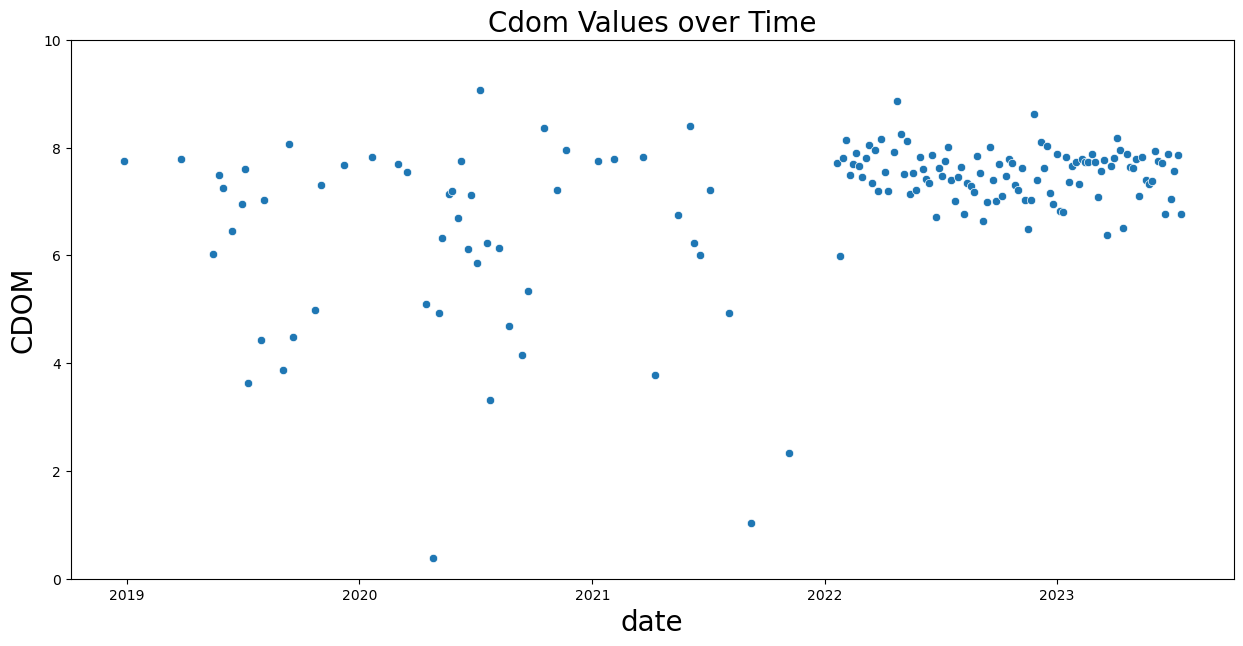

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)
ax.set_ylim(0,10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


In [17]:
def reflectance(img):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).select(STD_NAMES)
    return ee.Feature(None, {'date': img.date().format(), 'reflectance': reflectance_values})

s2_reflectance = s2.map(reflectance)
s2_list = s2_reflectance.reduceColumns(ee.Reducer.toList(2), ['date', 'reflectance']).values().get(0)
df_s2_reflectance = pd.DataFrame(s2_list.getInfo(), columns=['date', 'reflectance'])

# Convert date column to datetime and extract date only
df_s2_reflectance['date'] = pd.to_datetime(df_s2_reflectance['date']).dt.date

# Set the reflectance column values to a dictionary
df_s2_reflectance['reflectance'] = df_s2_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})
df_s2_reflectance

,date,reflectance
0,2018-12-17,{}
1,2018-12-17,{}
2,2018-12-22,{}
3,2018-12-22,{}
4,2018-12-27,{}
5,2018-12-27,"{'Aerosols': 5550, 'Blue': 8166, 'Green': 8020..."
6,2019-01-01,{}
7,2019-01-01,{}
8,2019-01-06,{}
9,2019-01-06,{}


In [18]:
# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)

          Band  Reflectance        Date
0     Aerosols       5550.0  2018-12-27
1         Blue       8166.0  2018-12-27
2        Green       8020.0  2018-12-27
3          Red       8121.0  2018-12-27
4     RedEdge1       8419.0  2018-12-27
5     RedEdge2       8164.0  2018-12-27
6     RedEdge4       8047.0  2018-12-27
7          NIR       7736.0  2018-12-27
8        SWIR1       1322.0  2018-12-27
9     Aerosols       6736.0  2019-03-27
10        Blue       9795.0  2019-03-27
11       Green       9674.0  2019-03-27
12         Red       9687.0  2019-03-27
13    RedEdge1       9939.0  2019-03-27
14    RedEdge2       9398.0  2019-03-27
15    RedEdge4       8879.0  2019-03-27
16         NIR       8366.0  2019-03-27
17       SWIR1        493.0  2019-03-27
18    Aerosols        752.0  2019-04-16
19        Blue        291.0  2019-04-16
20       Green        388.0  2019-04-16
21         Red        416.0  2019-04-16
22    RedEdge1        703.0  2019-04-16
23    RedEdge2        563.0  2019-04-16


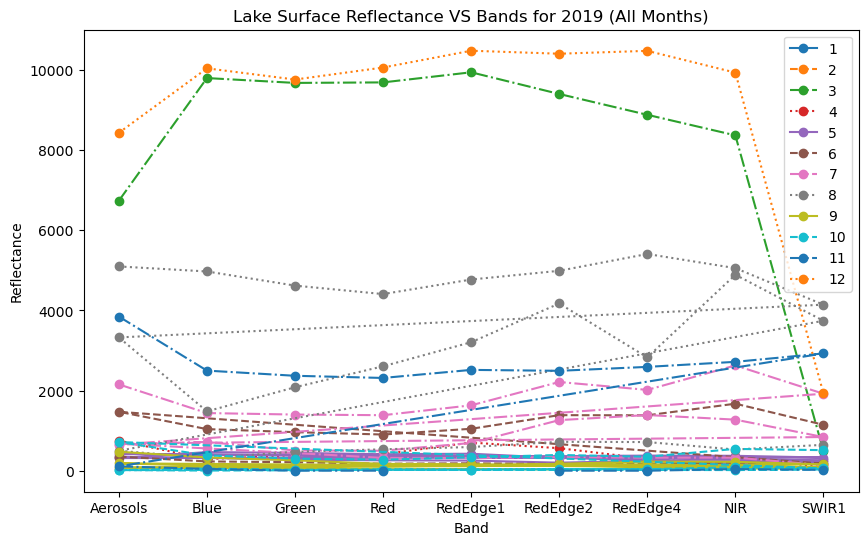

In [19]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                data_by_month[month]['band'].append(band)
                data_by_month[month]['reflectance'].append(value)

# Calculate average reflectance values for each month
averaged_data_by_month = {}
for month, data in data_by_month.items():
    averaged_data_by_month[month] = {
        'band': data['band'],
        'reflectance': data['reflectance']
    }

# Sort the averaged_data_by_month dictionary based on the keys (months) in ascending order
sorted_data_by_month = dict(sorted(averaged_data_by_month.items()))

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in sorted_data_by_month.items():
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    plt.plot(data['band'], data['reflectance'], linestyle=line_style, marker='o', label=month)
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Reflectance')
# plt.ylim(0, 0.15)
plt.title('Lake Surface Reflectance VS Bands for 2019 (All Months)')
plt.legend()
plt.show()
